# Feature Scaling and selection

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import *

In [2]:
df = load_csv('../data/processed/Treated_subscriptions_churn.csv')
df.head()

,months_subscribed,streaming_quality,subscription_type,monthly_plan_cost,total_revenue,subscription_canceled,app_usage_hours,last30d_usage_hours,customer_rating,promo_email_clicks,...,support_tickets_last6m,nps_score,is_active_last30d,gender_Male,payment_mode_Credit card (automatic),payment_mode_Electronic check,payment_mode_Mailed check,device_type_Mobile,device_type_SmartTV,total_revenue_log
0,1,1,0,29.85,29.85,0,4.1,125.9,3,3,...,0,9,1,0,0,1,0,1,0,3.429137
1,34,1,1,56.95,1889.50,0,5.1,177.9,4,2,...,0,7,1,1,0,0,1,1,0,7.544597
2,2,1,0,53.85,108.15,1,2.4,88.5,5,4,...,0,1,1,1,0,0,1,0,0,4.692723
3,45,1,1,42.30,1840.75,0,3.8,124.0,5,5,...,0,6,1,1,0,0,0,0,1,7.518471
4,2,2,0,70.70,151.65,1,6.3,182.8,5,2,...,0,3,1,0,0,1,0,1,0,5.028148


In [3]:
#Feature_Scaling: we will only fit the scaler for the train and will apply that same on test
# X and y saperation:
X = df.drop(["subscription_canceled","is_active_last30d","total_revenue"],axis=1)
y = df["subscription_canceled"]



In [4]:
#TEST_TRAIN Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16, stratify=y)



In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# 1. Define your groups
cols_minmax = ['streaming_quality', 'subscription_type', 'customer_rating','promo_email_clicks', 'num_profiles', 'support_tickets_last6m', 'nps_score']

cols_standard = ['months_subscribed', 'monthly_plan_cost', 'total_revenue_log','app_usage_hours', 'last30d_usage_hours']

# Note: All other columns (binary ones) are passed through automatically ('passthrough')

# 2. Create the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), cols_minmax),
        ('standard', StandardScaler(), cols_standard)
    ],
    remainder='passthrough'  # Keeps the binary columns as-is
)

# 3. Apply to your data
X_train_sc = preprocessor.fit_transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [6]:
X_train.columns


Index(['months_subscribed', 'streaming_quality', 'subscription_type',
       'monthly_plan_cost', 'app_usage_hours', 'last30d_usage_hours',
       'customer_rating', 'promo_email_clicks', 'num_profiles', 'auto_renew',
       'support_tickets_last6m', 'nps_score', 'gender_Male',
       'payment_mode_Credit card (automatic)', 'payment_mode_Electronic check',
       'payment_mode_Mailed check', 'device_type_Mobile',
       'device_type_SmartTV', 'total_revenue_log'],
      dtype='object')

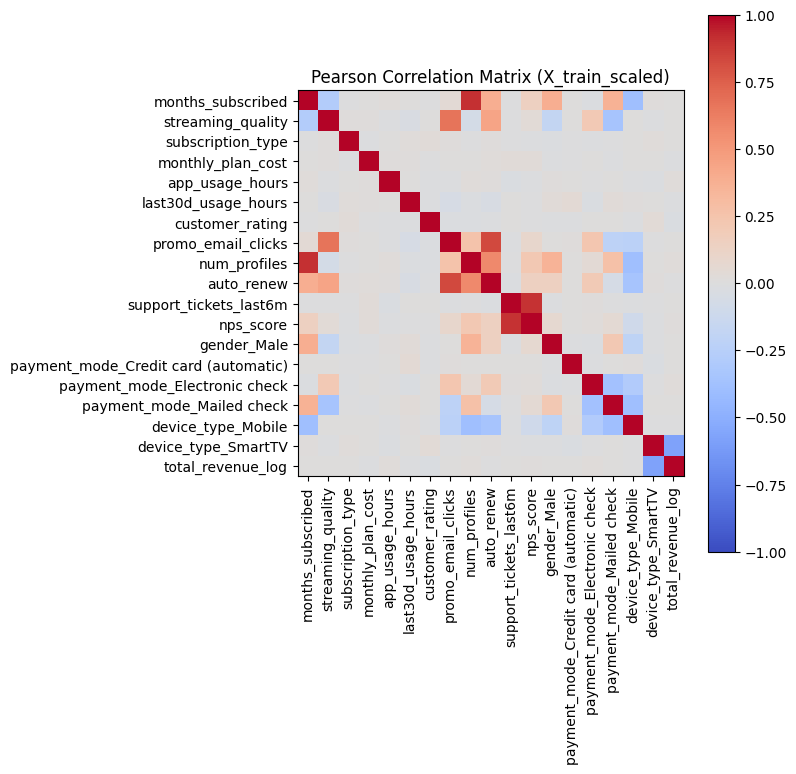

In [7]:
#Feature Selection:
df_scaled = pd.DataFrame(X_train_sc, columns=['months_subscribed', 'streaming_quality', 'subscription_type','monthly_plan_cost', 'app_usage_hours', 'last30d_usage_hours','customer_rating', 'promo_email_clicks', 'num_profiles', 'auto_renew','support_tickets_last6m', 'nps_score', 'gender_Male','payment_mode_Credit card (automatic)', 'payment_mode_Electronic check','payment_mode_Mailed check', 'device_type_Mobile','device_type_SmartTV', 'total_revenue_log'])

# Compute Pearson correlation matrix
corr_matrix = df_scaled.corr(method='pearson')

plt.figure(figsize=(8,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Pearson Correlation Matrix (X_train_scaled)")
plt.xticks(range(len(df_scaled.columns)), df_scaled.columns, rotation=90)
plt.yticks(range(len(df_scaled.columns)), df_scaled.columns)
plt.tight_layout()
plt.show()

In [8]:

# To store high-correlation pairs
high_corr_pairs = []

# Loop through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):   # avoid duplicates & self-correlation
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.6:
            pair = (
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                abs(corr_value)
            )
            high_corr_pairs.append(pair)

# Convert to DataFrame for a clean view
high_corr_df = (pd.DataFrame(high_corr_pairs,
                            columns=["Feature 1", "Feature 2", "Correlation"])).sort_values(by="Correlation",ascending=False)

high_corr_df

,Feature 1,Feature 2,Correlation
0,months_subscribed,num_profiles,0.906523
3,support_tickets_last6m,nps_score,0.901404
2,promo_email_clicks,auto_renew,0.832491
1,streaming_quality,promo_email_clicks,0.667569


In [9]:
# if going forward with Logistics Model then do Feature selection and remove high collinear features: ["num_profiles","support_tickets_last6m","promo_email_clicks"]
# and then you can proceed with Logistics Regression model with L1 (Lasso) regularization on the reduced, clean feature set.

# or

# if for some reason , dont want to drop any of these features then switch to a Tree-Based Model like XGBoost or Random Forest.
# Tree models are inherently robust to multicollinearity and do not suffer from coefficient instability. 

In [10]:




XTrain = pd.DataFrame(X_train_sc, columns=['months_subscribed', 'streaming_quality', 'subscription_type','monthly_plan_cost', 'app_usage_hours', 'last30d_usage_hours','customer_rating', 'promo_email_clicks', 'num_profiles', 'auto_renew','support_tickets_last6m', 'nps_score', 'gender_Male','payment_mode_Credit card (automatic)', 'payment_mode_Electronic check','payment_mode_Mailed check', 'device_type_Mobile','device_type_SmartTV', 'total_revenue_log'])
XTest = pd.DataFrame(X_test_sc, columns=['months_subscribed', 'streaming_quality', 'subscription_type','monthly_plan_cost', 'app_usage_hours', 'last30d_usage_hours','customer_rating', 'promo_email_clicks', 'num_profiles', 'auto_renew','support_tickets_last6m', 'nps_score', 'gender_Male','payment_mode_Credit card (automatic)', 'payment_mode_Electronic check','payment_mode_Mailed check', 'device_type_Mobile','device_type_SmartTV', 'total_revenue_log'])
YTrain,YTest = y_train, y_test

save_csv(XTrain,'../data/processed/XTrain.csv')
save_csv(XTest,'../data/processed/XTest.csv')
save_csv(YTrain,'../data/processed/YTrain.csv')
save_csv(YTest,'../data/processed/YTest.csv')

